# Tests of Transient Injection in Host Galaxies

### DESI Hack Day: May 21, 2018

| Participant    | Email |
| --- | --- |
| Ouail Kitouni (remotely)  | okitouni@u.rochester.edu |
| Segev BenZvi   | sbenzvi@ur.rochester.edu |
| Kelly Douglass | kellyadouglass@rochester.edu |

This is a test of the transient injection code in desisim specific to SNe Ia. The code in desisim.templates was written by John Moustakas and Or Graur. The goal of this activity is to exercise the code and pick out any issues. It looks like there is one issue related to the normalization of SNe Ia + hosts which we didn't have time to fix.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import desisim
from desisim import templates as tmpl

from astropy.io import fits

# Some plot formatting.
mpl.rc('font', size=16)

## Create BGS Spectra from Templates

Use the templates in DESI_BASIS_TEMPLATES to generate some BGS galaxy spectra.

In this case the RNG seeds are fixed and no additional transients are added to the generated spectra.

In [3]:
seed = [4265123084, 3502492979, 3696048575, 2734384221, 523476491, 867530900]

bgs = tmpl.BGS(add_SNeIa=False,minwave=3600.0, maxwave=10000.0, cdelt=0.2)
templates_bgs = bgs.make_templates(nmodel=len(seed), 
                                   zrange=(0.01, 0.4), 
                                   seed=seed,
                                   rmagrange=(15.0, 19.5), 
                                   oiiihbrange=(-1.3, 0.6), 
                                   logvdisp_meansig=(2.0, 0.17), 
                                   minhbetaflux=0.0, 
                                   sne_rfluxratiorange=(0.1, 1.0),
                                   redshift=None,
                                   mag=None, 
                                   vdisp=None, 
                                   input_meta=None,
                                   nocolorcuts=False,
                                   nocontinuum=False,
                                   agnlike=False,
                                   novdisp=False,
                                   restframe=False,
                                   verbose=False);

INFO:io.py:889:read_basis_templates: Reading /Users/sybenzvi/Documents/DESI/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits


In [4]:
wl = bgs.wave
bgs_fluxes = templates_bgs[0]
bgs_header = templates_bgs[2]

bgs_header

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
,,,,,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,erg / (cm2 s),erg / (cm2 s),Angstrom,Angstrom,,,,Dex,Dex,Dex,Dex,,Gyr,K,m / s2,
str10,str10,int32,int64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
BGS,,2391,2079091233,0.189082413698,16.7337,71.1538,202.546,416.559,641.308,521.138,-1.0,1.51784e-15,-1.0,2.95993,1.4529,205.050754243,0.686127,0.132932,0.393716,-0.445246,-0.481289,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,2603,420256928,0.209480839304,17.115,51.0656,142.564,251.587,261.167,204.142,-1.0,0.0,-1.0,0.0,1.55233,205.050754243,0.706921,0.436668,0.517693,-0.895911,-0.0828613,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,4311,2083182949,0.372462157388,16.9225,30.5321,170.218,427.166,729.614,515.66,-1.0,0.0,-1.0,0.0,1.94885,205.050754243,0.719207,-0.0936637,0.321115,-0.0398219,-0.0533934,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,3966,774718085,0.120108578814,16.1954,172.233,332.539,526.837,471.843,328.832,-1.0,2.20788e-15,-1.0,2.34246,1.33813,205.050754243,0.678192,-0.0485877,0.322864,-0.187903,-0.101206,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,6933,2503284579,0.275820309466,18.631,18.9854,35.2867,47.8134,37.8344,28.2434,-1.0,9.38657e-16,-1.0,9.75467,1.14554,205.050754243,0.712462,0.0562976,0.432764,-0.181781,-0.249716,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,3703,930675844,0.318397678086,17.9588,14.7636,65.5358,152.399,213.563,150.125,-1.0,0.0,-1.0,0.0,1.90645,205.050754243,0.694132,-0.5485,0.05034,0.0561915,-0.0653683,-1.0,-1.0,-1.0,-1.0,-1.0


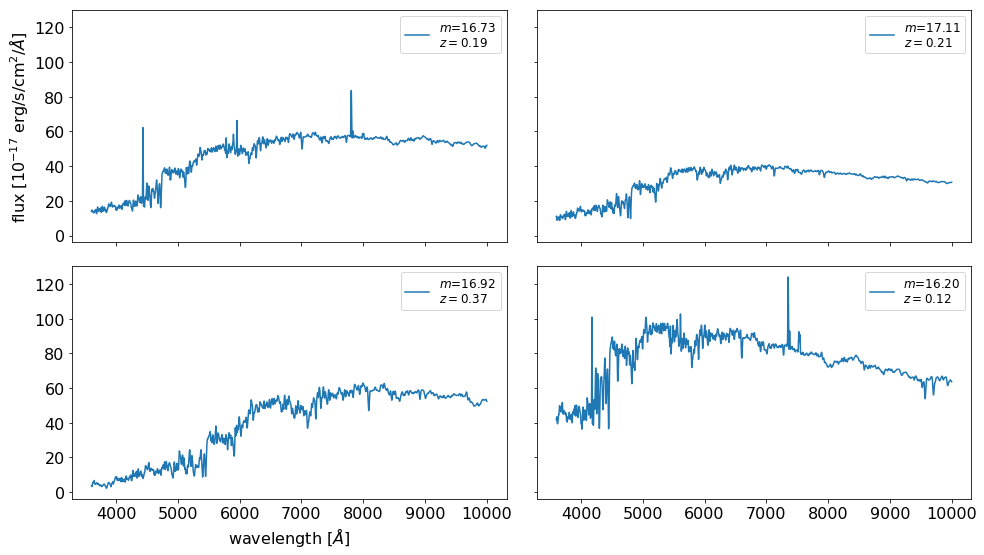

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
for ax, flux, hdr in zip(axes.flatten(), bgs_fluxes, bgs_header):
    z = hdr['REDSHIFT']
    m = hdr['MAG']
    ax.plot(wl, flux, label='$m$={:.2f}\n$z=${:.2f}'.format(m, z))
    ax.legend(fontsize=12)
axes[0][0].set(ylabel=r'flux [$10^{-17}$ erg/s/cm$^2$/$\AA$]')
axes[1][0].set(xlabel=r'wavelength [$\AA$]')
fig.tight_layout();

## Create BGS Spectra + SNe Ia

Use the functionality in desisim.templates to create BGS spectra with fluxes from SNe Ia.

In [6]:
bgs_sn = tmpl.BGS(add_SNeIa=True, minwave=3600.0, maxwave=10000.0, cdelt=0.2)
templates_bgs_sn = bgs_sn.make_templates(nmodel=len(seed),
                                         zrange=(0.01, 0.1),
                                         seed=seed,
                                         sne_rfluxratiorange=(0.3, 0.3001)
                                        );

INFO:io.py:889:read_basis_templates: Reading /Users/sybenzvi/Documents/DESI/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits
INFO:io.py:889:read_basis_templates: Reading /Users/sybenzvi/Documents/DESI/spectro/templates/basis_templates/v2.5/sne_templates_v1.0.fits


In [7]:
bgs_sn.normfilter, bgs_sn.normline

('decam2014-r', 'HBETA')

### Test of restflux. CAUTION: not official!

The GALAXY.restflux member is a local change that is not committed to desisim.templates. We did this just to look at the rest flux of a BGS galaxy with and without an SN Ia. The rest flux looks good... the BGS + SN Ia flux looks exactly like the sum of the two spectra.

WARNING: if you run the cell below using the main branch of desisim it will throw an exception.

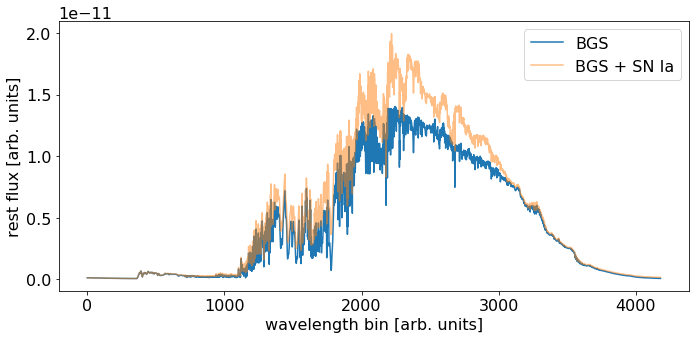

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(bgs.restflux[7][::10], label='BGS')
ax.plot(bgs_sn.restflux[7][::10], label='BGS + SN Ia', alpha=0.5)
ax.set(xlabel='wavelength bin [arb. units]',
       ylabel='rest flux [arb. units]')
ax.legend()
fig.tight_layout()

### Access Randomly Selected SN Ia Template

Examine the SN Ia template randomly selected by desisim.templates at three epochs: 10 days before max, maximum light, and 10 days after max.

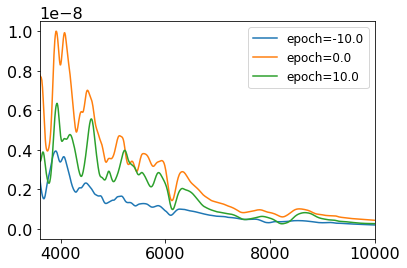

In [9]:
sne_baseflux = bgs_sn.sne_baseflux
sne_basemeta = bgs_sn.sne_basemeta

epoch0 = -10 #sne_basemeta['EPOCH'][0]
epoch1 =  10 #sne_basemeta['EPOCH'][-1]
epoch_max = 0.

for epoch in [epoch0, epoch_max, epoch1]:
    e = np.where(sne_basemeta['EPOCH']==epoch)[0][0]
    plt.plot(bgs.basewave[::10], sne_baseflux[e][::10], label='epoch={:.1f}'.format(epoch))
    plt.xlim(wl[0], wl[-1])
plt.legend(fontsize=12)

# np.where(sne_basemeta['EPOCH']==0)

# for i in range(20,24):
#     plt.plot(bgs_sn.sne_baseflux[i][::10])

## Plot Observed BGS + SN Ia Spectra

Show the BGS spectra alone and the same spectra (same RNG seeds) after adding randomly selected SNe Ia.

### Normalization Issue?

If you look at the spectra below, you'll notice that the normalization is fixed to the center of the r band at 6469.6 angstroms, so that when the SN Ia is added the g-band fluxes are bumped up and the z-band fluxes are reduced. This seems to be an artifact of normalization in desisim.templates to the decam2014-r filter. It's correct for galaxies but doesn't seem to be the right behavior for galaxies + transients.

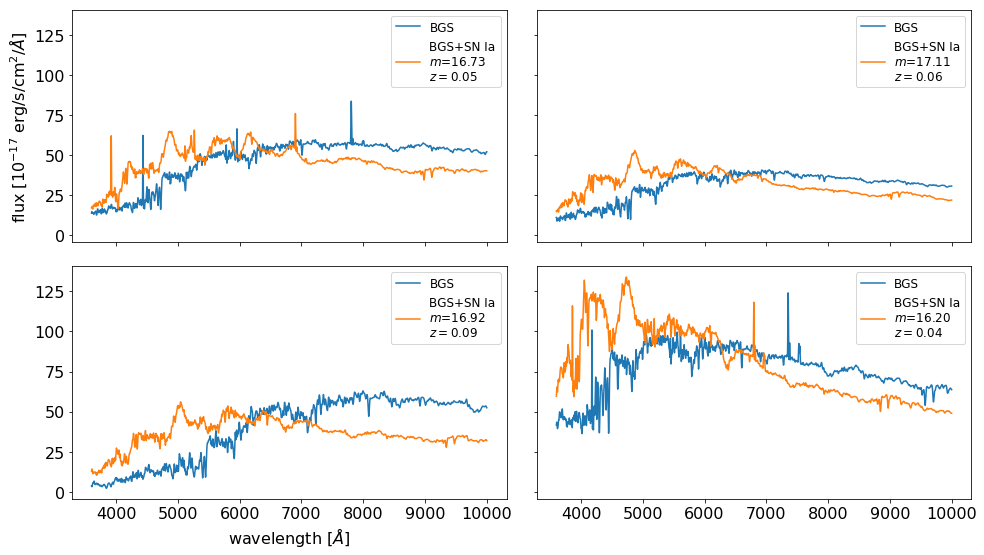

In [10]:
wl_sn = bgs.wave
bgs_sn_fluxes = templates_bgs_sn[0]
bgs_sn_header = templates_bgs_sn[2]

fig, axes = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
for ax, flux, flux_sn, hdr in zip(axes.flatten(), bgs_fluxes, bgs_sn_fluxes, bgs_sn_header):
    z = hdr['REDSHIFT']
    m = hdr['MAG']
    ax.plot(wl, flux, label='BGS'.format(m, z))
    ax.plot(wl, flux_sn, label='BGS+SN Ia\n$m$={:.2f}\n$z=${:.2f}'.format(m, z))
    ax.legend(fontsize=12)
axes[0][0].set(ylabel=r'flux [$10^{-17}$ erg/s/cm$^2$/$\AA$]')
axes[1][0].set(xlabel=r'wavelength [$\AA$]')
fig.tight_layout();

### More on the Normalization

Some more plots showing the normalization issue as a function of the SN flux ratio. As the ratio of the SN to galaxy flux increases, the reduction in the z-band fluxes and increase in the g-band fluxes get more extreme.

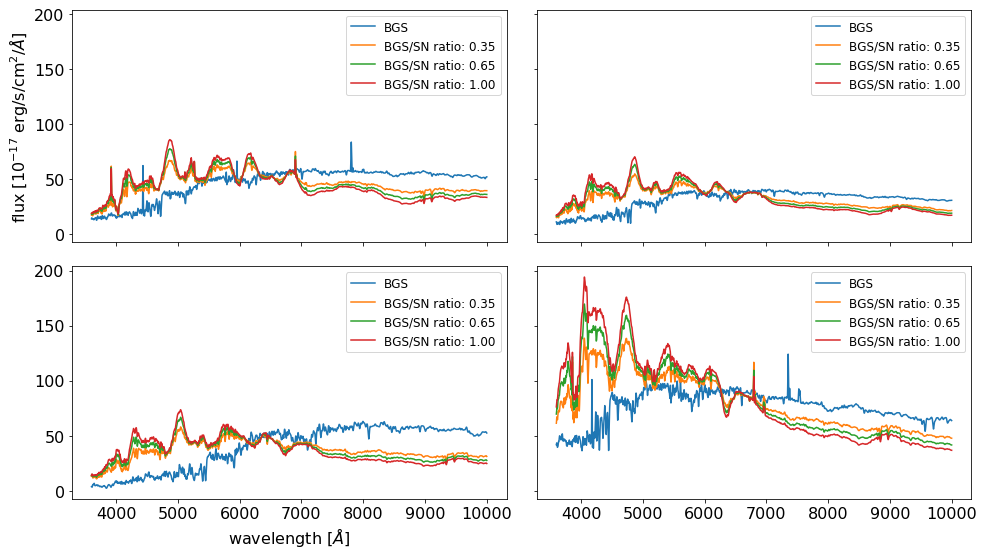

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
for ax, flux in zip(axes.flatten(), bgs_fluxes):
    ax.plot(wl, flux, label='BGS')

for fluxratio in [0.35, 0.65, 1.]:
    templates_bgs_sn_fr = bgs_sn.make_templates(nmodel=len(seed),
                                                zrange=(0.01, 0.1),
                                                seed=seed,
                                                sne_rfluxratiorange=(fluxratio, fluxratio+0.0001))

    bgs_sn_fluxes_fr = templates_bgs_sn_fr[0]
    bgs_sn_header_fr = templates_bgs_sn_fr[2]
    
    for ax, flux, flux_sn, hdr in zip(axes.flatten(), bgs_fluxes, bgs_sn_fluxes_fr, bgs_sn_header_fr):
        z = hdr['REDSHIFT']
        m = hdr['MAG']
        ax.plot(wl, flux_sn, label='BGS/SN ratio: {:.2f}'.format(fluxratio))

for ax in axes.flatten():
    ax.legend(fontsize=12)
axes[0][0].set(ylabel=r'flux [$10^{-17}$ erg/s/cm$^2$/$\AA$]')
axes[1][0].set(xlabel=r'wavelength [$\AA$]')
fig.tight_layout();

## Check of DECam Filters

The reduction in z and increase in g appears to be occurring because the code is attempting to maintain the same bolometric magnitude in galaxy+SN Ia as in just the galaxy alone. The normalization is controlled by the transmission of the photometric passbands, plotted below.

In [12]:
import speclite

In [14]:
speclite.filters.load_filters('decam2014-*').names

['decam2014-u',
 'decam2014-g',
 'decam2014-r',
 'decam2014-i',
 'decam2014-z',
 'decam2014-Y']

In [15]:
decam2014r = speclite.filters.load_filters('decam2014-r')
decam2014r.effective_wavelengths

<Quantity [ 6469.62203811] Angstrom>

Text(4400,0.53,'6469.6 $\\AA$')

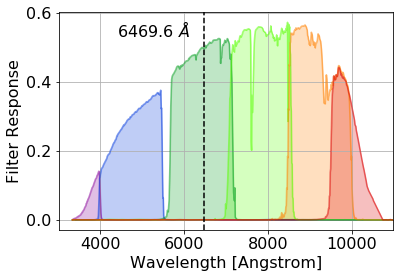

In [16]:
decam2014 = speclite.filters.load_filters('decam2014-*')
speclite.filters.plot_filters(decam2014, wavelength_limits=(3000,11000), legend_loc=None)
plt.axvline(6469.6, color='k', linestyle='--')
plt.text(4400, 0.53, r'6469.6 $\AA$')